# Memory In LangGraph


A very important feature of agentic system is remembering past chat history. 

LangGraph provides several ways of doing so - both in runtime memory and databases. 

We will explore both options, while also studying useful practises to avoid clogging message history with two many messages.

----
References:
- https://langchain-ai.github.io/langgraph/how-tos/memory/add-memory/
- https://langchain-ai.github.io/langgraph/concepts/persistence/#persistence

----

## 1. Short Term Memory

The easiest way to add memory to your LangGraph project is by using `InMemorySaver`. 

In order to do so, we just need to 

1. instantiate an instance of `InMemorySaver()` and then pass it as the `checkpointer` param in `.compile()`;
2. Pass a `thread_id` in graph config, which allows us to identify which conversation we are accessing. 

So let's use the checkpointer first:

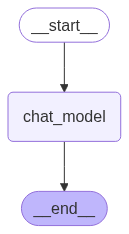

In [1]:
from langgraph.checkpoint.memory import InMemorySaver

from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

checkpointer = InMemorySaver()

# llm
load_dotenv("envs/.env")
llm = ChatOpenAI(model="gpt-4o")

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile(checkpointer=checkpointer)

# View
display(Image(graph.get_graph().draw_mermaid_png()))


And then we pass a thread id at graph invocation: 

In [2]:
from langchain_core.messages import HumanMessage

input_state = {"messages": [HumanMessage(content="Hello, I am Matteo.")]}

In [3]:
result= graph.invoke(input_state, config={"configurable" : {"thread_id" : 1}})
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, I am Matteo.
================================== Ai Message ==================================

Hello, Matteo! How can I assist you today?


Will it remember who I am?

In [4]:
result= graph.invoke(
    input=
    {
        "messages": [HumanMessage(content="Hello, what is my name?")]
    },
    config=
    {
        "configurable" : {"thread_id" : 1}
    }
)
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, I am Matteo.
================================== Ai Message ==================================

Hello, Matteo! How can I assist you today?
================================ Human Message =================================

Hello, what is my name?
================================== Ai Message ==================================

You mentioned that your name is Matteo.


Super easy right?

## 2. Long Term Memory



What if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some [more advanced checkpointers](https://langchain-ai.github.io/langgraph/how-tos/memory/add-memory/#use-in-production) that support external databases.

A good starting point here is the SqliteSaver checkpointer. Sqlite is a small, fast, highly popular SQL database.

In [5]:
%pip install --quiet -U langgraph-checkpoint-sqlite

Note: you may need to restart the kernel to use updated packages.


If we supply `":memory:"` it creates an in-memory Sqlite database.

In [6]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)


But, if we supply a db path, then it will create a database for us!

In [7]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver  # sync saver

# Create a checkpoint saver that uses SQLite
conn = sqlite3.connect("example_db/checkpoints.db", check_same_thread=False)
longterm_memory = SqliteSaver(conn)

> **Note:** if you already had a database and wanted to use the existing one: 
>
>```python
>conn = sqlite3.connect(<db_path>, check_same_thread=False)
>memory = SqliteSaver(conn)
>```

Now, we just re-compile with our sqlite checkpointer.

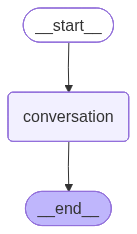

In [8]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(MessagesState)
workflow.add_node("conversation", chat_model_node)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_edge("conversation", END)

# Compile
graph = workflow.compile(checkpointer=longterm_memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times.

In [9]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Matteo")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="I am a researcher :)")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello, Matteo! How can I assist you today?
================================== Ai Message ==================================

You mentioned that your name is Matteo. How can I help you further?
================================== Ai Message ==================================

That's great to hear, Matteo! What field do you research in?


## 3. Memory Management

Mmeory is great, but tokens are expensive. What if our model builds up a chat history of hundred of thousands of token? 

This would both slow down our model, and rip a whole in our wallet at each run.

Luckily we have several ways to manage that.

### 3.1 Using `RemoveMessage` 

One way of filtering input messages from chat history is by using the `RemoveMessage` object. 

In order to do so, we need to also specify messages id for our messages. 